# Predicting price of listings in Boston and Seattle

In this project, the objective is building a model to predict the price of a listing in Boston or in Seattle, at the same time we discover some importance variables to compare how is the relationship between rating in these two places.

First of all, we import the needed libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import os
if os.path.exists('figures'):
    os.rmdir('figures')
else:
    os.makedirs('figures')

In [49]:
import shutil
if os.path.exists('hola'):
    shutil.rmtree('hola')
else:
    os.makedirs('hola')

PermissionError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'hola'

In [2]:
def charge_databases(city: str):
    """
    This function allows you to upload your databases in Python. It considers that every folder has three files:
    a file with listings of the Airbnb places, a calendar with all reservations and a review file with some 
    comments about the offered service by Airbnb in the place they selected.
    All files must be saved in data folder inside a folder with label city_Airbnb
    INPUT - 
            city - string - origin from data
    OUTPUT - 
            dictionary of pandas dataframe with:
            - listings - pandas dataframe - including full descriptions and average review score
            - reviews - pandas dataframe - including unique id for each reviewer and detailed comments
            - calendar - pandas dataframe - including listing id and the price and availability for that day
    """
    listings = pd.read_csv( './data/' + city + '_Airbnb/listings.csv')
    listings['city'] = city
    calendar = pd.read_csv( './data/' + city + '_Airbnb/calendar.csv')
    calendar['city'] = city
    reviews = pd.read_csv( './data/' + city + '_Airbnb/reviews.csv')
    reviews['city'] = city
    dictionary = {
        'listings' : listings,
        'calendar': calendar,
        'reviews': reviews
    }
    return dictionary

In [3]:
boston_dir = "Boston"
seattle_dir = "Seattle"

boston = charge_databases(boston_dir)
seattle = charge_databases(seattle_dir)

In [4]:
rows_boston = boston['listings'].shape[0]
cols_boston = boston['listings'].shape[1]

rows_seattle = seattle['listings'].shape[0]
cols_seattle = seattle['listings'].shape[1]

print('There are {cols_boston} columns with {rows_boston} observations in Boston listings, \
meanwhile in Seattle listings there are {cols_seattle} \
columns with {rows_seattle} observations.'.format(cols_boston = cols_boston,
                                                        rows_boston = rows_boston,
                                                        rows_seattle = rows_seattle,
                                                        cols_seattle = cols_seattle))

There are 95 columns with 3585 observations in Boston listings, meanwhile in Seattle listings there are 92 columns with 3818 observations.


We try to answer three questions in this notebook about the collected information:
1. How much is the difference between opinion about hosts in Seattle and Boston?
2. What are the variables that most affect the price in Boston? Or in Seattle?
3. How much profit could a place obtain with Airbnb?

With this objective, a summary table can be prepared to analyze the information of the Boston and Seattle tables.

In [5]:
def summary_table(listings_df, calendar_df, reviews_df):
    
    """
    This function allows you write a summary table with information of calendar, reviews and listings in a single table.
    INPUT - 
            listings - pandas dataframe - including full descriptions and average review score
            reviews - pandas dataframe - including unique id for each reviewer and detailed comments
            calendar - pandas dataframe - including listing id and the price and availability for that day
    OUTPUT - 
            summary_table - pandas dataframe - All information of tables in a single one.
            
    """
    
    calendar_details = calendar_df[calendar_df.price.notnull()].groupby('listing_id').agg(
        count_reservations = ('date', 'count'),
        max_price = ('price', 'max'),
        min_price = ('price', 'min'),
    ).reset_index()
    
    reviews_details = reviews_df.groupby('listing_id').agg(
        first_date = ('date', 'min'),
        last_date = ('date', 'max'),
        count_users = ('reviewer_id', lambda x: x.nunique()),
        count_reviews = ('id', 'count'),
    ).reset_index()
    
    df = pd.merge(listings_df,calendar_details, how='left', left_on=['id'],right_on=['listing_id'])
    df = pd.merge(df,reviews_details, how='left', left_on=['id'],right_on=['listing_id'])
    
    # Select only the columns that it be useful in the model
    columns_to_study = ['summary', 'neighborhood_overview', 'thumbnail_url', 'medium_url',
                        'xl_picture_url', 'host_location', 'host_response_time',
                        'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
                        'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
                        'city', 'is_location_exact', 'property_type', 'room_type', 'accommodates',
                        'bathrooms', 'bedrooms', 'bed_type', 'amenities', 'price', 'security_deposit',
                        'cleaning_fee', 'guests_included', 'minimum_nights', 'maximum_nights', 
                        'number_of_reviews' , 'review_scores_rating', 'review_scores_accuracy',
                        'cancellation_policy', 'require_guest_profile_picture', 'host_listings_count',
                        'require_guest_phone_verification', 'reviews_per_month', 'count_reservations',
                        'max_price', 'min_price', 'count_users', 'count_reviews']
    
    return df[columns_to_study]

In [6]:
# Summary table for Boston listings
listings = boston['listings']
calendar = boston['calendar']
reviews = boston['reviews']

summary_boston = summary_table(listings, calendar, reviews)

# Summary table for Seattle listings
listings = seattle['listings']
calendar = seattle['calendar']
reviews = seattle['reviews']

summary_seattle = summary_table(listings, calendar, reviews)

In [7]:
def compare_score(df_1, df_2, col, title = None, limits = None, save_fig = None):
    var_1 = df_1[col]
    var_2 = df_2[col]
    plt.figure(figsize=(10,8))
    plt.hist([var_1, var_2], color=['r','b'], alpha=0.6,
                  bins = 40, density = True,
                 label=['Seattle', 'Boston']);
    plt.title(title) if title is not None else None;
    plt.xlim(limits) if limits is not None else None;
    plt.legend();
    plt.savefig('figures/' + save_fig) if save_fig is not None else None;
    plt.show();

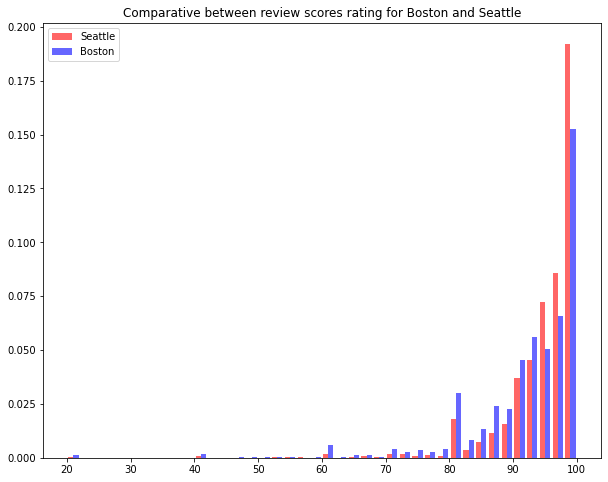

In [8]:
title = 'Comparative between review scores rating for Boston and Seattle'
save_fig = 'comparative_boston_seattle_review_scores_rating.jpg'
compare_score(summary_seattle, summary_boston, 'review_scores_rating', title, save_fig = save_fig)

It can be seen how affects the rating depending the city. Nevertheless, there are some details that a first glance are impercentibles. For this, we can observe an enlarged view of this figure (since 70 in x axis):

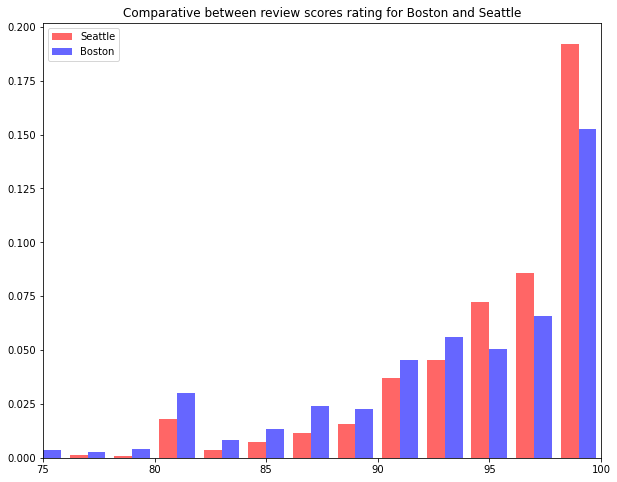

In [9]:
limits = (75,100)
save_fig = 'comparative_boston_seattle_review_scores_rating_amplied.jpg'
compare_score(summary_seattle, summary_boston, 'review_scores_rating', title, limits, save_fig = save_fig)

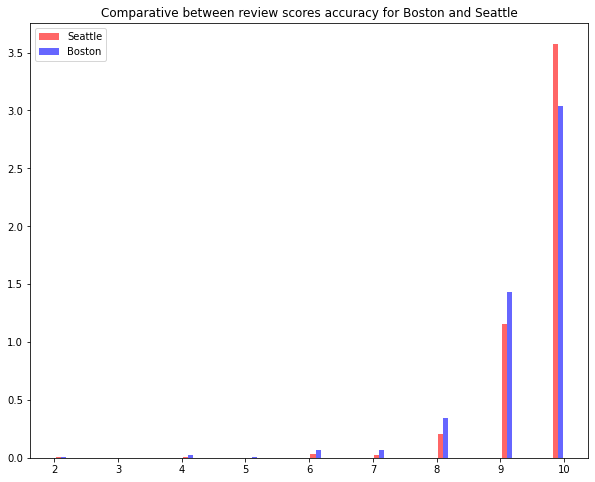

In [10]:
title = 'Comparative between review scores accuracy for Boston and Seattle'
save_fig = 'comparative_boston_seattle_review_scores_accuracy.jpg'
compare_score(summary_seattle, summary_boston, 'review_scores_accuracy', title, save_fig = save_fig)

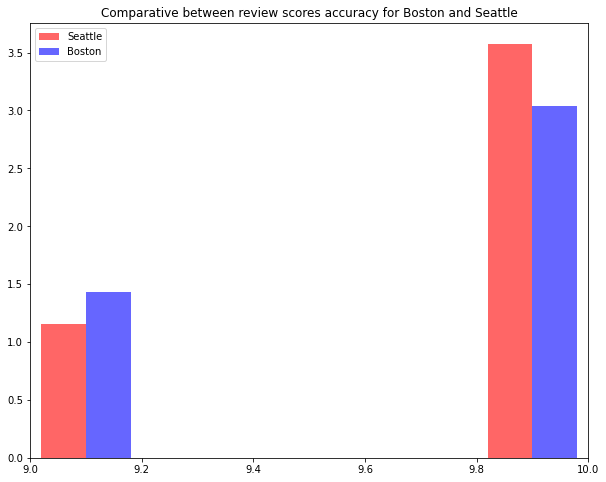

In [11]:
limits = (9,10)
save_fig = 'comparative_boston_seattle_review_scores_accuracy_amplied.jpg'
compare_score(summary_seattle, summary_boston, 'review_scores_accuracy', title, limits, save_fig = save_fig)

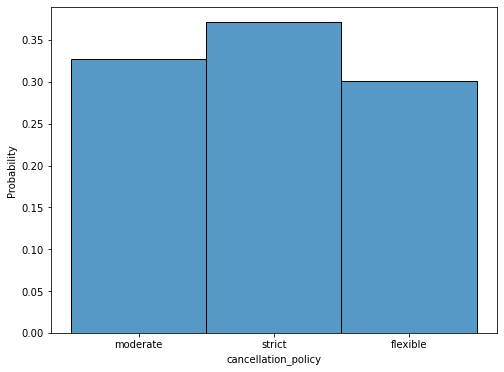

In [12]:
plt.figure(figsize = (8,6))
sns.histplot(data = summary_seattle, x = 'cancellation_policy', stat= 'probability');
save_fig = 'figures/cancellation_policy_distribution.jpg'
plt.savefig(save_fig)


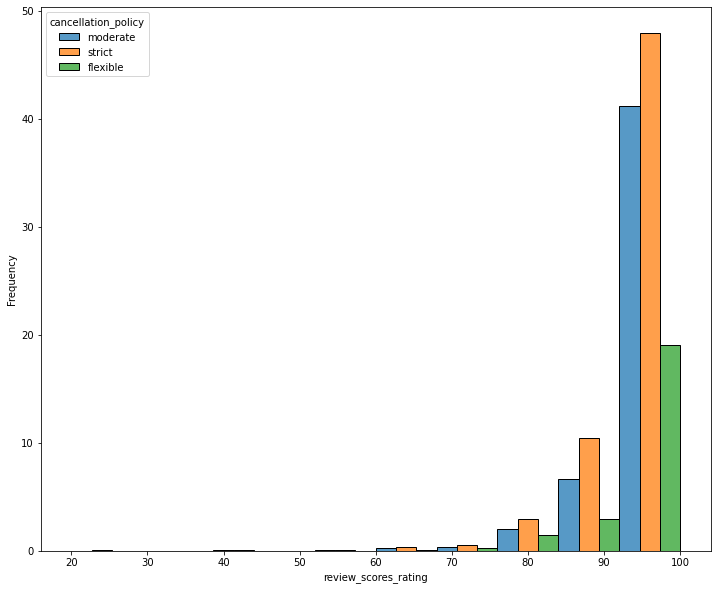

In [13]:
plt.figure(figsize = (12,10))
sns.histplot(data = summary_seattle, x = 'review_scores_rating', hue = 'cancellation_policy',
             stat = 'frequency', multiple = 'dodge', bins = 10);
save_fig = 'figures/review_scores_rating_by_cancellation_policy.jpg'
plt.savefig(save_fig)

The information in the tables are presented without preprocessing, then there are some null values in the data.

In [14]:
def clean_data(df):
    """
    This functions allows you build a clean data with all requirements to train the model
    
    INPUT
        df - pandas dataframe 
    
    OUTPUT
        df - Complete table with all information
        X - A matrix holding all of the variables you want to consider when predicting the response
        y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    """

    # Drop NA rows in response column
    df = df.dropna(subset=['price'], axis = 0)
    
    
    # Convert text columns by lenght in each row
    cols_text = ['neighborhood_overview', 'summary']
    for col in cols_text:
        df['len_' + col] = df[col].str.len().fillna(0)
    df.drop(cols_text, axis = 1, inplace = True)
    
    
    # Determine length of each row by the number of element in the list
    df['host_num_methods_verification'] = df.host_verifications.str.strip('][').str.split(',').apply(lambda x: len(x))
    df['num_amenities'] = df.amenities.str.strip('}{').str.split(',').apply(lambda x : len(x))
    df.drop(['amenities', 'host_verifications'], axis = 1, inplace = True)
    
    
    # Convert Columns True or False in numeric
    cols_true_or_false = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
                         'is_location_exact','require_guest_profile_picture','require_guest_phone_verification']
    for col in cols_true_or_false:
        df[col] = df[col].replace({'f': 0, 't': 1})
    
    
    # Determine if host live in the same city of listing location
    df['host_city_location'] = df.host_location.str.split(',').apply(
        lambda d: d if isinstance(d, list) else ['Unknown']
    ).map(lambda x : x[0])
    df['host_city_location'] = df['host_city_location'] == df['city']
    df['host_city_location'] = df['host_city_location'].astype(int)
    df.drop(['host_location', 'city'], axis = 1, inplace = True)
    
    
    # Convert percentage in numeric type
    median_host = df.host_response_rate.str.rstrip('%').astype(float).median()
    df['host_response_rate'] = df.host_response_rate.str.rstrip('%').astype(float).fillna(median_host)

    median_host = df.host_acceptance_rate.str.rstrip('%').astype(float).median()
    df['host_acceptance_rate'] = df.host_acceptance_rate.str.rstrip('%').astype(float).fillna(median_host)

    
    # Replace current values
    cols_money = ['price','security_deposit','cleaning_fee','max_price','min_price']
    for col in cols_money:
        df[col] = df[col].replace({'\$':'', ',':''}, regex = True).astype(float).fillna(0)

    
    # Modify column to show if exists or not any value for a column
    true_false_cols = [col for col in df.columns.tolist() if 'url' in col]
    for col in true_false_cols:
        df['is_' + col] = df[col].notnull().astype(int)
    df.drop(true_false_cols, axis = 1, inplace = True)
    
    
    # Fill NA's anywhere it is needed
    num_vars = df.drop(['price'], axis = 1).select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    date_vars = df.drop(['price'], axis = 1).select_dtypes(include=['datetime64']).columns
    for col in date_vars:
        df[col].fillna((df[col].mode()[0]),inplace=True)
    
    
    # Generate dummy variables in table
    col_dummies = df.drop(['price'], axis = 1).select_dtypes(include=['object']).copy().columns
    
    for var in col_dummies:
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # Split in X and y dataframes
    X = df.drop(['price'], axis = 1)
    y = df[['price']]
    return df, X, y

In [15]:
#Use the function to create X and y
summary_boston, X_boston, y_boston = clean_data(summary_boston)
summary_seattle, X_seattle, y_seattle = clean_data(summary_seattle)

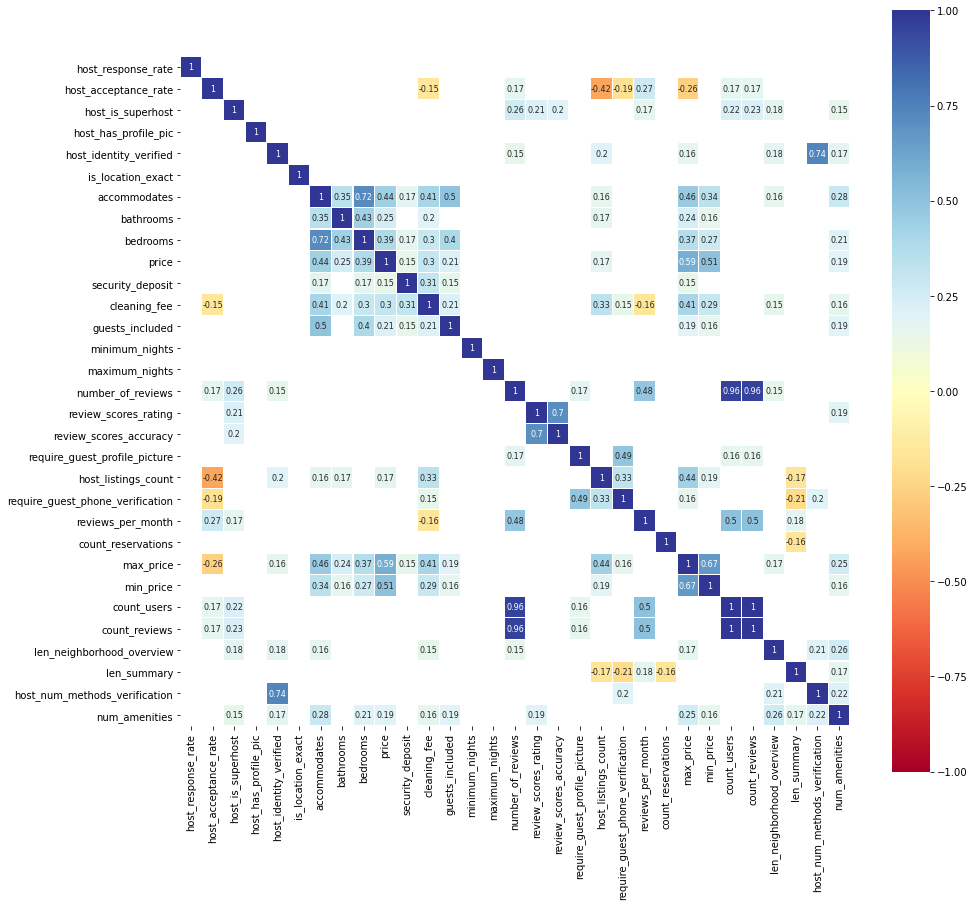

In [16]:
corr = summary_boston.select_dtypes(['float64', 'int64']).corr()
plt.figure(figsize = (15,14))
sns.heatmap(corr[(corr > 0.15)| (corr < -0.15)], 
            cmap='RdYlBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
save_fig = 'figures/corr_summary_boston.jpg'
plt.savefig(save_fig)

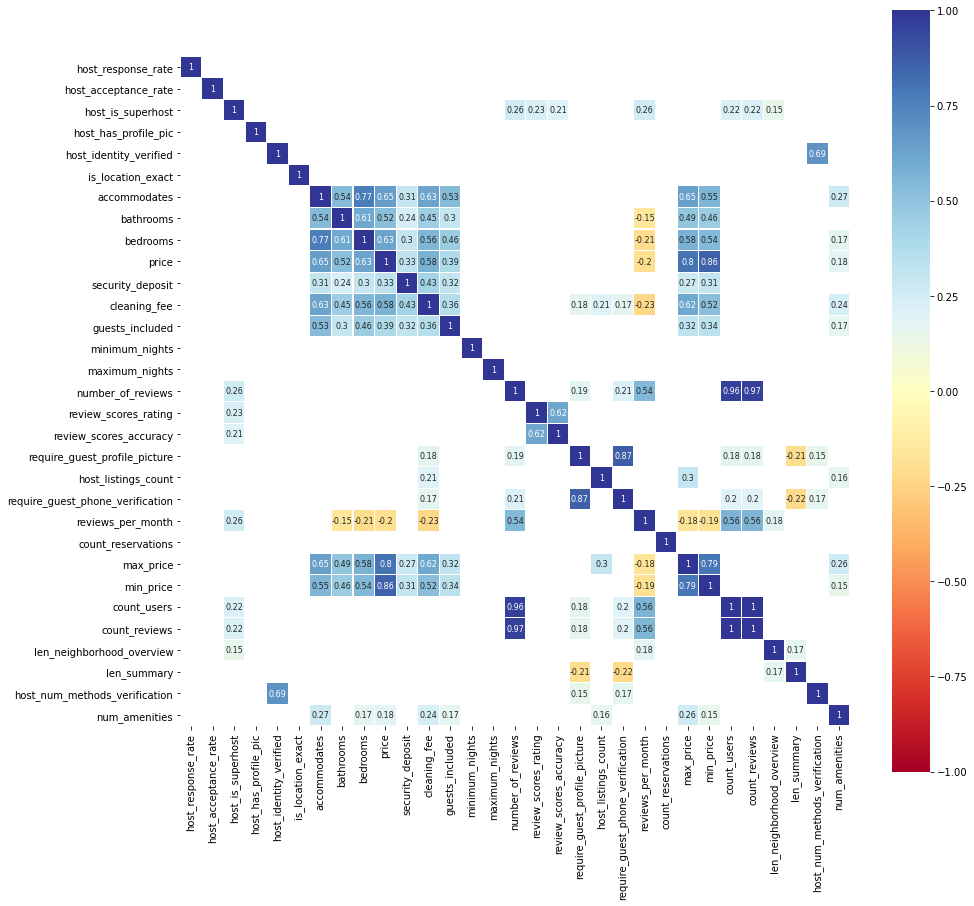

In [17]:
corr = summary_seattle.select_dtypes(['float64', 'int64']).corr()
plt.figure(figsize = (15,14))
sns.heatmap(corr[(corr > 0.15)| (corr < -0.15)], 
            cmap='RdYlBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
save_fig = 'figures/corr_summary_seattle.jpg'
plt.savefig(save_fig)

# Training models to predict the price of listings

At first glance, determining the price of listings can be represent an important feature when you want to include a new place in the database. Then, we build and train two models: a linear regression and a decision tree regressor. These are build on Scikit learn library and a MinMaxScaler was added to optimize the results.

In [18]:
def build_and_train_models(X, y, test_size = .30, seed = 42):
    
    # Standarized data
    scaler = MinMaxScaler()
    X_new = scaler.fit_transform(X)
    
    # Prepare train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size = test_size,
                                                            random_state = seed)
    
    # Instantiate a linear model regression
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train);
    
    y_test_preds = lm_model.predict(X_test)
    print('R2 score for linear model:',r2_score(y_test, y_test_preds))
    
    # Instantiate a decision tree model regression
    dt_model = DecisionTreeRegressor() 
    dt_model.fit(X_train, y_train)
    
    y_test_preds = dt_model.predict(X_test)
    print('R2 score for decision tree model:',r2_score(y_test, y_test_preds))
    
    models =  {'lm_model' : lm_model,
               'dt_model' : dt_model}
    return models

### For Boston:

In [19]:
models = build_and_train_models(X_boston, y_boston)

R2 score for linear model: -8410.50768022838
R2 score for decision tree model: 0.42604464845745826


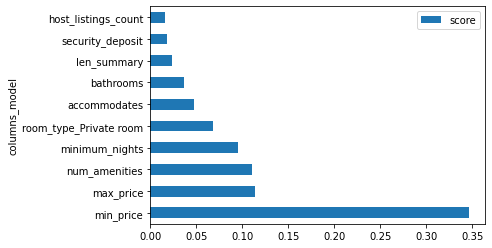

In [20]:
feature_importance = pd.DataFrame()
feature_importance['columns_model'] = X_boston.columns
feature_importance['score'] = models['dt_model'].feature_importances_
feature_importance.sort_values('score', ascending= False, inplace = True)
feature_importance.head(10).plot(kind = 'barh', x = 'columns_model', y = 'score');
save_fig = 'figures/feature_importance_boston.jpg'
plt.savefig(save_fig)

### For Seattle:

In [21]:
models = build_and_train_models(X_seattle, y_seattle)

R2 score for linear model: -3.7564713497442473e+18
R2 score for decision tree model: 0.7373541500643541


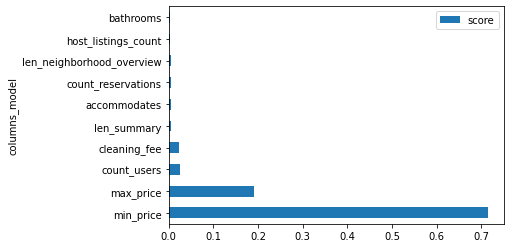

In [22]:
feature_importance = pd.DataFrame()
feature_importance['columns_model'] = X_seattle.columns
feature_importance['score'] = models['dt_model'].feature_importances_
feature_importance.sort_values('score', ascending= False, inplace = True)
feature_importance.head(10).plot(kind = 'barh', x = 'columns_model', y = 'score');
save_fig = 'figures/feature_importance_seattle.jpg'
plt.savefig(save_fig)